# Quantitative Risk Management

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantRiskManagement/blob/main/NOTEBOOKS/8_IRS_Sensitivities.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.


3+4

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [17]:
import sys
sys.path.append('../CODE')  # Adjust the path as necessary

In [18]:
import pytorch_spline

(0.0, 0.037106)

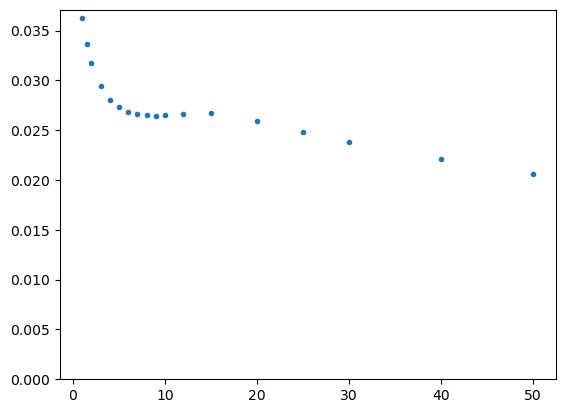

In [53]:
swap_rates = pd.read_csv('../DATA/IR_Swap.csv')

swap_rates['Rate'] /= 100

plt.plot(swap_rates['Mat (yrs)'], swap_rates['Rate'], '.')
plt.ylim((0))

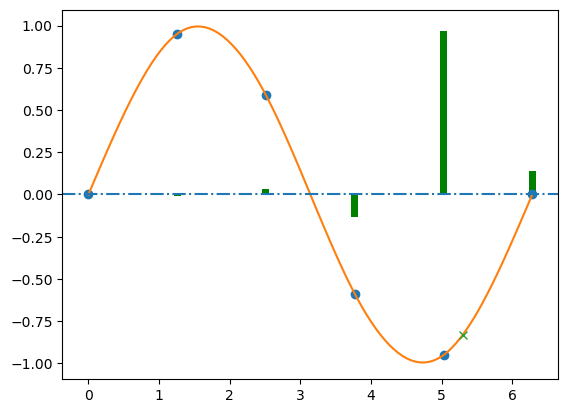

In [42]:
x = np.linspace(0,2*np.pi, 6)
y = np.sin(x)
x = torch.tensor(x, requires_grad=False)
y = torch.tensor(y, requires_grad=True)

x_grid = torch.linspace(0,2*np.pi, 100,requires_grad=False)

spline = pytorch_spline.NaturalCubicSpline_Torch(x,y)


with torch.no_grad():
    y_grid = spline.evaluate_spline(x_grid)

plt.plot(x, y.detach(), 'o')
plt.plot(x_grid, y_grid)

x_0 = torch.tensor(5.3, requires_grad=False)

y_0 = spline.evaluate_spline(x_0)

y_0.backward()

grad = y.grad

plt.bar(x = x, height= grad, width= 0.1, color = 'green')
plt.plot(x_0, y_0.detach(), 'x')
plt.axhline(linestyle = '-.')


In [76]:
class ir_curve:

    def __init__(self, time_pillars, rates):

        time_pillars = torch.concatenate([torch.tensor([0]), time_pillars])
        rates = torch.concatenate([torch.tensor([0]), rates])
        time_times_rate = rates * time_pillars

        self.interpolator = pytorch_spline.NaturalCubicSpline_Torch(time_pillars,time_times_rate)

    def zero_coupon_rates(self, time_pillars):

        return self.interpolator.evaluate_spline(time_pillars) / time_pillars
    
    def discount_factors(self, time_pillars):

        return torch.exp(-self.interpolator.evaluate_spline(time_pillars))
        

(0.0, 0.03910003514729934)

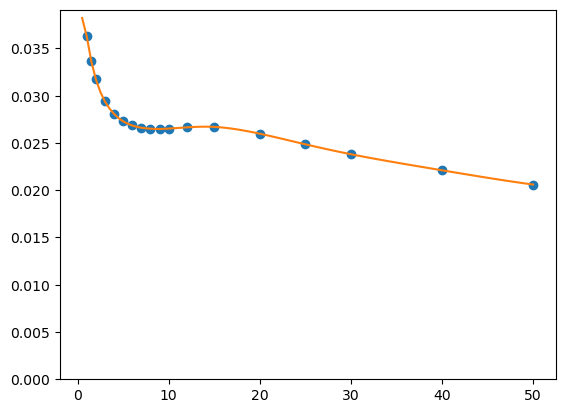

In [79]:
time = torch.tensor(swap_rates['Mat (yrs)'].values, requires_grad=False)
rates = torch.tensor(swap_rates['Rate'].values, requires_grad=False) 

curve = ir_curve(time, rates)

time_grid = torch.linspace(0,50,100, requires_grad=False)

zc_rates = curve.zero_coupon_rates(time_grid)

plt.plot(time, rates, 'o')
plt.plot(time_grid, zc_rates)
plt.ylim(0.0)




In [56]:
torch.concatenate([torch.tensor([0]), x])

tensor([0., 1., 2., 3.])